# Adaptation
This notebook is to showcase the role of adapatation. 

As usual we begin by loading the libraries

In [4]:
from __future__ import print_function
import subprocess
import sys 
sys.path.append('../')

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from mpl_toolkits.axes_grid1 import make_axes_locatable

from connectivity_functions import get_beta, get_w, softmax
from connectivity_functions import calculate_probability, calculate_coactivations
from data_transformer import transform_normal_to_neural_single
from data_transformer import transform_neural_to_normal_single
from network import BCPNN

np.set_printoptions(suppress=True)
sns.set(font_scale=2.0)
%matplotlib inline

Then we load the necessary git file

In [3]:
run_old_version = False
if run_old_version:
    hash_when_file_was_written = 'f59761905a03127d9422883ce5404eff3ff547fe'
    hash_at_the_moment = subprocess.check_output(["git", 'rev-parse', 'HEAD']).strip()
    print('Actual hash', hash_at_the_moment)
    print('Hash of the commit used to run the simulation', hash_when_file_was_written)
    subprocess.call(['git', 'checkout', hash_when_file_was_written])
    

## Network with adaptation
### Load the patterns, and instantiate the network

In [5]:
# First we load the patterns and calculate the probabilities, initial weight and bias
pattern1 = transform_normal_to_neural_single(np.array((1, 0, 0, 0, 0)))
pattern2 = transform_normal_to_neural_single(np.array((1, 0, 0, 0, 1)))
patterns = [pattern1, pattern2]

P = calculate_coactivations(patterns)
p = calculate_probability(patterns)

w = get_w(P, p)
beta = get_beta(p)

In [7]:
# Then we set the paraemeters and intantiate the network
tau_z_post = 0.240
tau_z_pre = 0.240
g_a = 80
tau_a = 2.7

nn = BCPNN(beta, w, p_pre=p, p_post=p, p_co=P, tau_z_post=tau_z_post, tau_z_pre=tau_z_pre,
           tau_a=tau_a, g_a=g_a, M=2)

Now we the time course and run the network

In [8]:
dt = 0.01
T = 10
time = np.arange(0, T + dt, dt)

history_o = np.zeros((time.size, beta.size))
history_s = np.zeros_like(history_o)
history_z_pre = np.zeros_like(history_o)
history_z_post = np.zeros_like(history_o)
history_a = np.zeros_like(history_o)

for index_t, t in enumerate(time):
    nn.update_continuous(dt)
    history_o[index_t, :] = nn.o
    history_s[index_t, :] = nn.s
    history_z_pre[index_t, :] = nn.z_pre
    history_z_post[index_t, :] = nn.z_post
    history_a[index_t, :] = nn.a

x = transform_neural_to_normal_single(nn.o)

#### Do the plotting

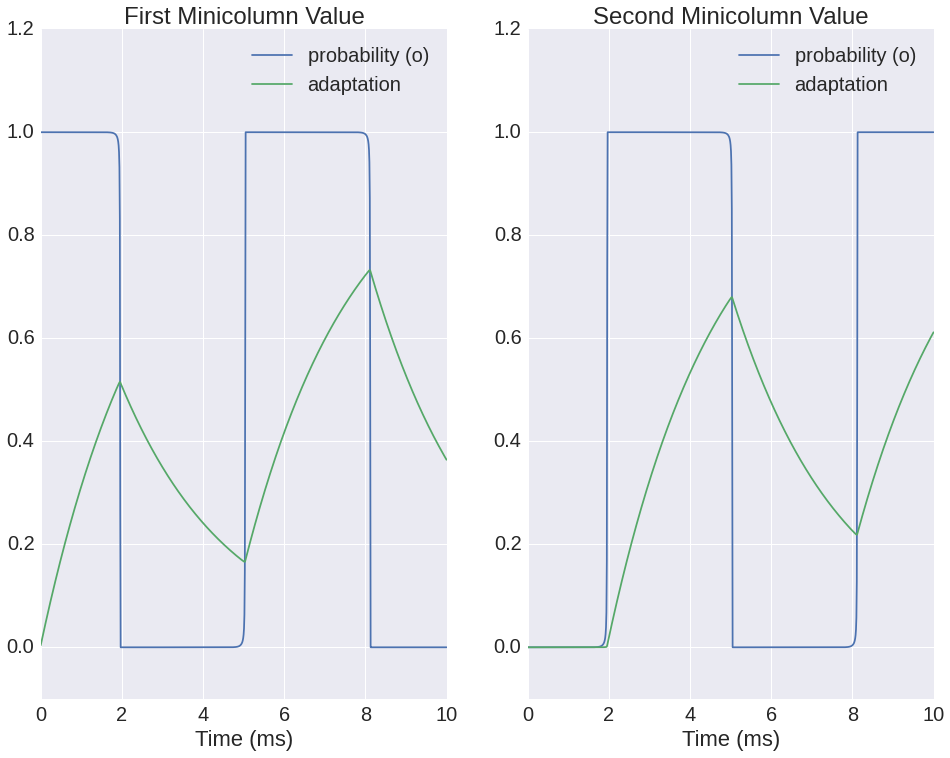

In [10]:
# Plotting goes here
gs = gridspec.GridSpec(1, 2)
fig = plt.figure(figsize=(16, 12))

ax1 = fig.add_subplot(gs[0, 0])
ax1.plot(time, history_o[:, 8], label='probability (o)')
ax1.plot(time, history_a[:, 8], label='adaptation')

ax1.set_title('First Minicolumn Value')
ax1.set_xlabel('Time (ms)')
ax1.set_ylim([-0.1, 1.2])
ax1.legend()

ax2 = fig.add_subplot(gs[0, 1])
ax2.plot(time, history_o[:, 9], label='probability (o)')
ax2.plot(time, history_a[:, 9], label='adaptation')

ax2.set_title('Second Minicolumn Value')
ax2.set_xlabel('Time (ms)')
ax2.set_ylim([-0.1, 1.2])
ax2.legend()

As we can see we start with the first unit which is winning but after a time adaptation (which follows the probability with a time constant tau_a) catches up and pushes the value down. After this the normalization kicks in and the other minicolumn is pushed to 1, the adaptation of thse second minicolumn starts growing consequently until it kicks it down and this starts a periodic phenomena. 

#### Return to the original git

Here we return to the master version

In [11]:
if run_old_version:
    subprocess.call(['git', 'checkout', 'master'])